# Modeling — NBA Win Predictor (SQL + ML)

This notebook trains and evaluates ML models on the SQL-engineered dataset.

Key points:
- **Binary classification**: predict `y_win`.
- **Time-based split** (no random shuffling).
- Compare a linear baseline (Logistic Regression) with a non-linear model (HistGradientBoostingClassifier).


## Setup

In [1]:
import duckdb
import pandas as pd
import numpy as np

basepath = "~/NBA-games-ML-pet-project/"
DB_PATH = basepath + "nba.duckdb"  # created by src/train.py
con = duckdb.connect(DB_PATH)

def list_tables(con) -> set[str]:
    df = con.execute("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'main' AND table_type = 'BASE TABLE'
    """).df()
    return set(df["table_name"].tolist())

def list_views(con) -> set[str]:
    df = con.execute("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'main' AND table_type = 'VIEW'
    """).df()
    return set(df["table_name"].tolist())

views = list_views(con)
tables = list_tables(con)
views, tables

views = list_views(con)
tables = list_tables(con)

if "v_teams" not in views and "teams" in tables:
    con.execute("""
    CREATE OR REPLACE VIEW v_teams AS
    SELECT
      team_id,
      full_name,
      abbreviation,
      city,
      state,
      year_founded
    FROM teams;
    """)
    views.add("v_teams")

if "v_games" not in views and "games" in tables:
    con.execute("""
    CREATE OR REPLACE VIEW v_games AS
    SELECT
      game_id,
      season,
      CAST(game_date AS DATE) AS game_date,
      team_id,
      opponent_team_id,
      CAST(is_home AS BOOLEAN) AS is_home,
      wl,
      CAST(pts AS DOUBLE) AS pts,
      CAST(fg_pct AS DOUBLE) AS fg_pct,
      CAST(fg3_pct AS DOUBLE) AS fg3_pct,
      CAST(ft_pct AS DOUBLE) AS ft_pct,
      CAST(reb AS DOUBLE) AS reb,
      CAST(ast AS DOUBLE) AS ast,
      CAST(tov AS DOUBLE) AS tov
    FROM games;
    """)
    views.add("v_games")

# refresh sets
views = list_views(con)
tables = list_tables(con)



## Pick the dataset view

In [2]:

dataset_view = "v_training_dataset_enriched" if "v_training_dataset_enriched" in views else "v_training_dataset"
named_view = None
if "v_training_dataset_enriched_named" in views:
    named_view = "v_training_dataset_enriched_named"
elif "v_training_dataset_named" in views:
    named_view = "v_training_dataset_named"

dataset_view, named_view


('v_training_dataset_enriched', 'v_training_dataset_enriched_named')

## Load dataset

In [3]:
df = con.execute(f"SELECT * FROM {dataset_view}").df()
df["game_date"] = pd.to_datetime(df["game_date"])
df = df.sort_values("game_date").reset_index(drop=True)
df.head()


,game_id,season,game_date,team_id,opponent_team_id,is_home,y_win,rest_days,pts_avg_l5,reb_avg_l5,...,opp_fg_pct_avg_l5,opp_fg3_pct_avg_l5,opp_ft_pct_avg_l5,opp_winrate_l5,star_pts_avg_l5_sum,star_min_avg_l5_avg,star_pm_avg_l5_avg,opp_star_pts_avg_l5_sum,opp_star_min_avg_l5_avg,opp_star_pm_avg_l5_avg
0,22400078,2024,2024-10-25,1610612755,1610612761,False,0,2,109.0,49.0,...,0.419,0.387,0.759,0.0,59.0,31.000000,-14.666667,44.0,22.666667,-15.666667
1,22400079,2024,2024-10-25,1610612766,1610612737,False,0,2,110.0,56.0,...,0.488,0.321,0.717,1.0,68.0,33.000000,6.666667,73.0,33.333333,7.666667
2,22400080,2024,2024-10-25,1610612739,1610612765,True,1,2,136.0,36.0,...,0.432,0.273,0.857,0.0,65.0,25.333333,27.000000,59.0,32.000000,-5.333333
3,22400077,2024,2024-10-25,1610612753,1610612751,True,1,2,116.0,57.0,...,0.440,0.395,0.760,0.0,74.0,25.333333,25.000000,66.0,33.333333,-4.666667
4,22400082,2024,2024-10-25,1610612763,1610612745,False,0,2,126.0,41.0,...,0.369,0.302,0.800,0.0,73.0,28.666667,-1.000000,67.0,35.333333,-0.333333


## Time split (train/val/test)
We split by time to mimic real forecasting: train on past, test on future.

In [4]:
def time_split(df, date_col="game_date", test_size=0.2, val_size=0.1):
    df = df.sort_values(date_col).reset_index(drop=True)
    n = len(df)
    n_test = int(round(n * test_size))
    n_val = int(round(n * val_size))
    test = df.iloc[-n_test:]
    val = df.iloc[-(n_test + n_val):-n_test] if n_val > 0 else df.iloc[0:0]
    train = df.iloc[:-(n_test + n_val)]
    return train, val, test

train_df, val_df, test_df = time_split(df)
len(train_df), len(val_df), len(test_df)


(3469, 496, 991)

## Feature/target split

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score

target = "y_win"
drop_cols = ["game_id", "season", "game_date", "team_id", "opponent_team_id", target]
feature_cols = [c for c in df.columns if c not in drop_cols]

X_train, y_train = train_df[feature_cols], train_df[target]
X_val, y_val = val_df[feature_cols], val_df[target]
X_test, y_test = test_df[feature_cols], test_df[target]

len(feature_cols), feature_cols[:12]


(25,
 ['is_home',
  'rest_days',
  'pts_avg_l5',
  'reb_avg_l5',
  'ast_avg_l5',
  'tov_avg_l5',
  'fg_pct_avg_l5',
  'fg3_pct_avg_l5',
  'ft_pct_avg_l5',
  'winrate_l5',
  'opp_rest_days',
  'opp_pts_avg_l5'])

## Train models

In [6]:
lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=2000))
])

hgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingClassifier(random_state=42))
])

lr.fit(X_train, y_train)
hgb.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a fe

## Evaluate

In [7]:
def eval_model(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return {
        "roc_auc": roc_auc_score(y, proba) if len(np.unique(y)) > 1 else None,
        "logloss": log_loss(y, proba),
        "accuracy": accuracy_score(y, pred),
    }

results = pd.DataFrame({
    "lr_val": eval_model(lr, X_val, y_val),
    "lr_test": eval_model(lr, X_test, y_test),
    "hgb_val": eval_model(hgb, X_val, y_val),
    "hgb_test": eval_model(hgb, X_test, y_test),
}).T

results


,roc_auc,logloss,accuracy
lr_val,0.914348,0.362425,0.858871
lr_test,0.946316,0.301199,0.861756
hgb_val,0.879708,0.459031,0.826613
hgb_test,0.748519,0.768453,0.697275


## Pick best model (by validation LogLoss)

In [8]:
best = lr if results.loc["lr_val", "logloss"] <= results.loc["hgb_val", "logloss"] else hgb
best_name = "lr" if best is lr else "hgb"
best_name


'lr'

## Interpretability (Logistic Regression)
For a linear model, coefficients indicate direction/strength of influence.

In [9]:
coefs = pd.Series(lr.named_steps["model"].coef_[0], index=feature_cols).sort_values(ascending=False)
coefs.head(20).to_frame("coef")


,coef
winrate_l5,1.288437
ft_pct_avg_l5,0.564770
rest_days,0.403465
fg_pct_avg_l5,0.373850
is_home,0.373800
fg3_pct_avg_l5,0.283844
star_min_avg_l5_avg,0.064575
opp_tov_avg_l5,0.050810
star_pm_avg_l5_avg,0.033677
ast_avg_l5,0.024714


In [10]:
coefs.tail(20).to_frame("coef")


,coef
fg3_pct_avg_l5,0.283844
star_min_avg_l5_avg,0.064575
opp_tov_avg_l5,0.050810
star_pm_avg_l5_avg,0.033677
ast_avg_l5,0.024714
opp_reb_avg_l5,0.021956
opp_star_pts_avg_l5_sum,0.019927
pts_avg_l5,0.006773
opp_pts_avg_l5,-0.007702
star_pts_avg_l5_sum,-0.019405


## Probability calibration
Checks if predicted probabilities align with observed win rates.

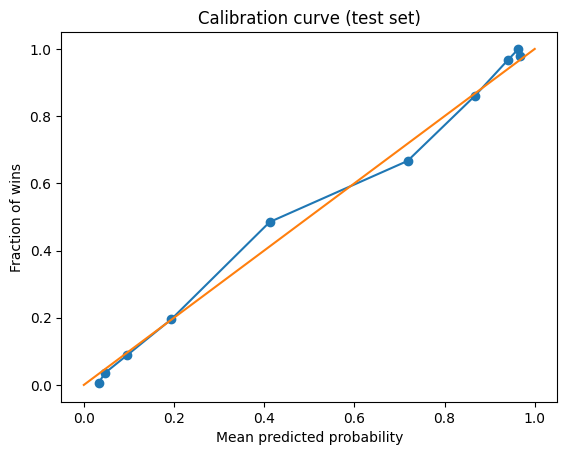

In [11]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

proba = best.predict_proba(X_test)[:, 1]
frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1])
plt.title("Calibration curve (test set)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of wins")
plt.show()


## Save notebook artifacts (optional)
In production, rely on `src/train.py`. This is useful for quick experiments.

In [13]:
import joblib
from pathlib import Path

artifacts = Path("artifacts_notebook")
artifacts.mkdir(exist_ok=True)

joblib.dump({"model": best, "feature_cols": feature_cols, "dataset_view": dataset_view}, artifacts / "model.joblib")
results.to_json(artifacts / "metrics.json", orient="index", indent=2)
str(artifacts)
con.close()